# Predicting the 2022 World Cup in Qatar

#### Data Preparation

In [10]:
import pandas as pd
results = pd.read_csv('results.csv')

In [11]:
results.loc[len(results.index)] = ['2022-11-16', 'United Arab Emirates', 'Argentina', 0.0, 5.0, 'Friendly', 'Abu Dhabi', 'United Arab Emirates', False]

we'll only be using the matches after the last world cup into account

In [12]:
results["date"] = pd.to_datetime(results["date"])
results.dropna(inplace=True)

In [13]:
results = results[(results["date"] >= "2018-8-1")].reset_index(drop=True)
results.sort_values("date").head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,2018-08-04,Belize,Barbados,1.0,0.0,Friendly,San Pedro,Belize,False
1,2018-08-04,Palestine,Iraq,0.0,3.0,Friendly,Al-Ram,Palestine,False
2,2018-08-15,Guatemala,Cuba,3.0,0.0,Friendly,Guatemala City,Guatemala,False
3,2018-08-18,Andorra,United Arab Emirates,0.0,0.0,Friendly,Grödig,Austria,True
4,2018-08-18,Grenada,Jamaica,1.0,5.0,Friendly,St. George's,Grenada,False


we'll also want to the FIFA rankings to later cross-reference

In [14]:
rank = pd.read_csv("fifa_ranking-2022-10-06.csv")
rank["rank_date"] = pd.to_datetime(rank["rank_date"])
rank = rank[(rank["rank_date"] >= "2018-8-1")].reset_index(drop=True)

minor adjustments*

In [15]:
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States")

Merge results - rank

In [16]:
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()

In [17]:
df_wc_ranked = results.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)

df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)

I'm rooting for Argentina, so let's see their last few games

In [18]:
df_wc_ranked[(df_wc_ranked.home_team == "Argentina") | (df_wc_ranked.away_team == "Argentina")].tail(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
2547,2021-11-12,Uruguay,Argentina,0.0,1.0,FIFA World Cup qualification,Montevideo,Uruguay,False,1625.67,1645.42,15.0,3.0,1738.79,1725.31,6.0,0.0
2629,2021-11-16,Argentina,Brazil,0.0,0.0,FIFA World Cup qualification,San Juan,Argentina,False,1738.79,1725.31,6.0,0.0,1820.36,1811.73,2.0,0.0
2739,2022-01-27,Chile,Argentina,1.0,2.0,FIFA World Cup qualification,Calama,Chile,False,1543.42,1541.33,24.0,0.0,1750.51,1750.51,5.0,0.0
2768,2022-02-01,Argentina,Colombia,1.0,0.0,FIFA World Cup qualification,Córdoba,Argentina,False,1750.51,1750.51,5.0,0.0,1607.15,1607.15,16.0,0.0
2834,2022-03-25,Argentina,Venezuela,3.0,0.0,FIFA World Cup qualification,Buenos Aires,Argentina,False,1766.99,1750.51,4.0,-1.0,1411.45,1409.14,58.0,-1.0
2892,2022-03-29,Ecuador,Argentina,1.0,1.0,FIFA World Cup qualification,Guayaquil,Ecuador,False,1458.63,1448.27,44.0,-2.0,1766.99,1750.51,4.0,-1.0
2953,2022-06-01,Italy,Argentina,0.0,3.0,CONMEBOL–UEFA Cup of Champions,Paris,France,True,1723.31,1740.77,6.0,0.0,1765.13,1766.99,4.0,0.0
3037,2022-06-05,Argentina,Estonia,5.0,0.0,Friendly,Pamplona,Spain,True,1765.13,1766.99,4.0,0.0,1169.06,1176.50,110.0,4.0
3230,2022-09-23,Argentina,Honduras,3.0,0.0,Friendly,Miami Gardens,United States,True,1770.65,1770.65,3.0,0.0,1299.69,1299.69,80.0,0.0
3298,2022-09-27,Argentina,Jamaica,3.0,0.0,Friendly,Harrison,United States,True,1770.65,1770.65,3.0,0.0,1382.06,1382.06,62.0,0.0


#### Features Engineering

We'll want to create features that might have an impact on match outcomes. 
possible features based on previous match:
- goals scored and conceded (both sides)
- points earned (W/D/L)
- friendly / qualification
- rank and rank change

In [19]:
df = df_wc_ranked

which team won and points gained

In [20]:
def result_finder(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])

results = df.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)

In [21]:
df[["result", "home_team_points", "away_team_points"]] = results

In [22]:
# ranking difference
df["rank_diff"] = df["rank_home"] - df["rank_away"]

# goal difference (home)
df["goal_diff"] = df["home_score"] - df["away_score"]

# points 
df["points_home_by_rank"] = df["home_team_points"]/df["rank_away"]
df["points_away_by_rank"] = df["away_team_points"]/df["rank_home"]

I'll separate the dataset into home team's and away team's dataset to remove the 'home' and 'away'

In [23]:
home_team = df[["date", "home_team", "home_score", "away_score", "rank_home", "rank_away","rank_change_home", "total_points_home", "result", "rank_diff", "points_home_by_rank", "home_team_points"]]

away_team = df[["date", "away_team", "away_score", "home_score", "rank_away", "rank_home","rank_change_away", "total_points_away", "result", "rank_diff", "points_away_by_rank", "away_team_points"]]

In [24]:
home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]

away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]

combine them for feature creation

In [25]:
team_stats = home_team.append(away_team)

#this column will be used to calculate features for simulation
team_stats_raw = team_stats.copy()

Now we create predictive features:

In [26]:
stats_val = []

for index, row in team_stats.iterrows():
    team = row["team"]
    date = row["date"]
    past_games = team_stats.loc[(team_stats["team"] == team) & (team_stats["date"] < date)].sort_values(by=['date'], ascending=False)
    last5 = past_games.head(5)
    
    # avg goals thus far
    goals = past_games["score"].mean()
    # avg goals in the last  games
    goals_l5 = last5["score"].mean()
    
    # avg goals conceded thus far
    goals_suf = past_games["suf_score"].mean()
    # avg goals conceded in the last 5 games
    goals_suf_l5 = last5["suf_score"].mean()
    
    # avg rank of teams faced thus far
    rank = past_games["rank_suf"].mean()
    # avg rank of teams faced in the last 5 games
    rank_l5 = last5["rank_suf"].mean()
    
    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]#qtd de pontos ganhos
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1] 
    else:
        points = 0
        points_l5 = 0


    # avg points  
    gp = past_games["team_points"].mean()
    # avg points in the last 5 games
    gp_l5 = last5["team_points"].mean()
    
    # rank-normalized
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()
    
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5])

In [27]:
stats_cols = ["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5", "rank_mean", "rank_mean_l5", "points_mean", "points_mean_l5", "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", "game_points_rank_mean_l5"]

stats_df = pd.DataFrame(stats_val, columns=stats_cols)

full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

separate again for adding in features

In [28]:
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

select only the made features

In [29]:
home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]

removing 'home' and 'away' again for re-merge

In [30]:
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

In [31]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)

full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

We will now quantify game importance (qualification / friendly)

In [32]:
def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x)) 

In [33]:
full_df = pd.get_dummies(full_df, columns=["is_friendly"])

#### Data Analysis

Now we select only the columns that will help in features analysis. We want to know if the created features have any predictive power

In [34]:
base_df = full_df[["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score","result", "rank_diff", "rank_change_home", "rank_change_away", 'home_goals_mean',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5', 'away_points_mean', 'away_points_mean_l5','home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5','away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5',
       'is_friendly_0', 'is_friendly_1']]

# rid of NaN's
base_df_no_fg = base_df.dropna()

In [35]:
df = base_df_no_fg

draws are complicated, so we'll assign them as lose games for the home team. making it a binary problem

In [36]:
def no_draw(x):
    if x == 2:
        return 1
    else:
        return x
    
df["target"] = df["result"].apply(lambda x: no_draw(x))

c:\Users\zakki\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Do the features have a different distribution depending on the target?

In [37]:
data1 = df[list(df.columns[8:20].values) + ["target"]]
data2 = df[df.columns[20:]]

In [38]:
scaled = (data1[:-1] - data1[:-1].mean()) / data1[:-1].std()
scaled["target"] = data1["target"]
violin1 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

scaled = (data2[:-1] - data2[:-1].mean()) / data2[:-1].std()
scaled["target"] = data2["target"]
violin2 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

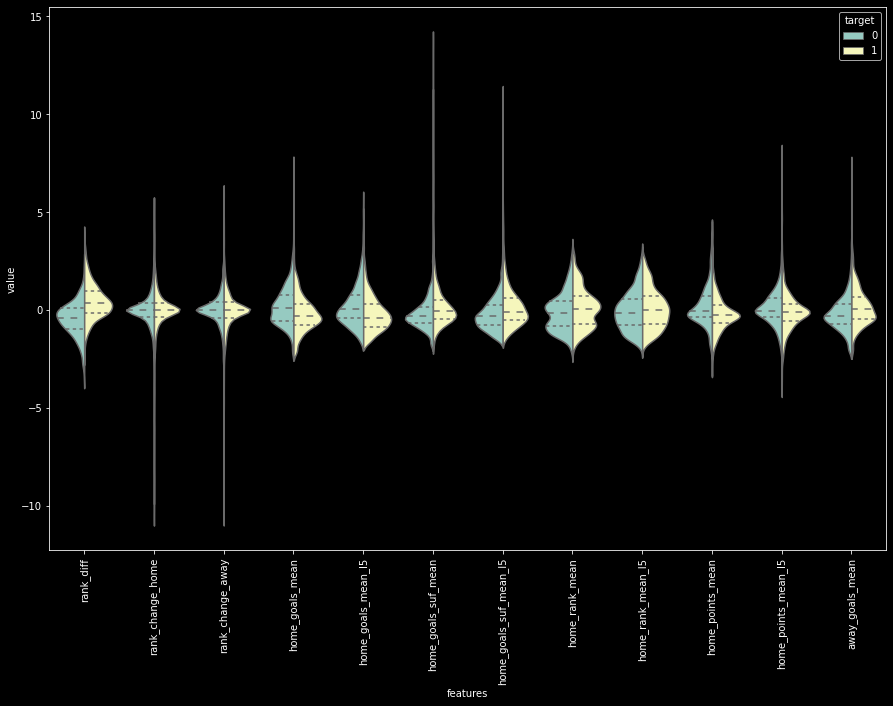

In [39]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use(['dark_background'])
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin1,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

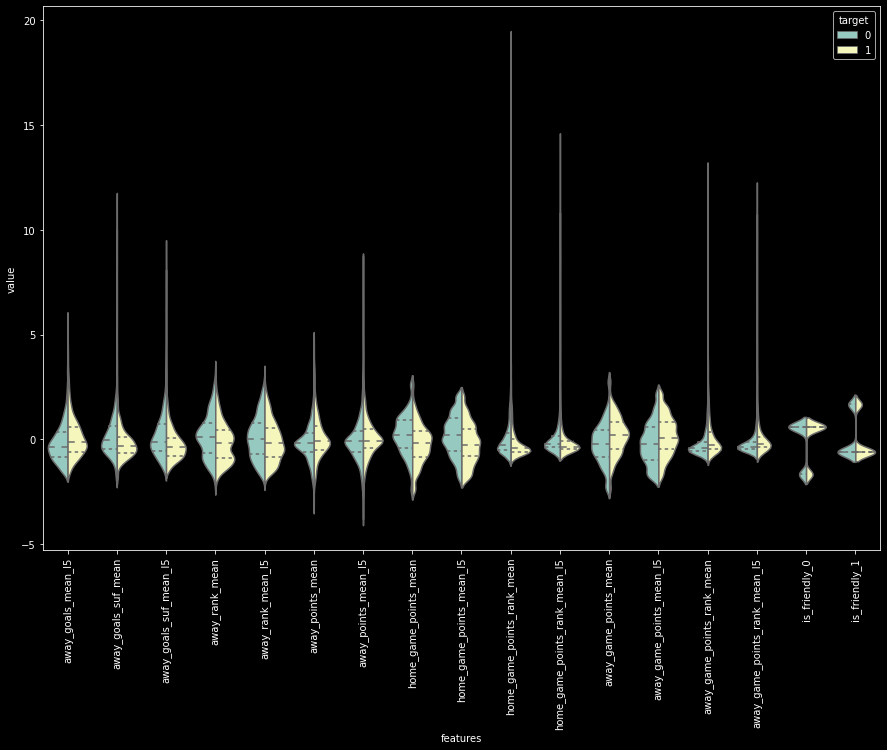

In [40]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin2,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

It looks like rank difference is the only go separator of the data. We can create similar features though...

In [41]:
dif = df.copy()
dif.loc[:, "goals_dif"] = dif["home_goals_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_mean_l5"]
dif.loc[:, "goals_suf_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_suf_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_made_suf_dif"] = dif["home_goals_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_made_suf_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_suf_made_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_suf_made_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_mean_l5"]

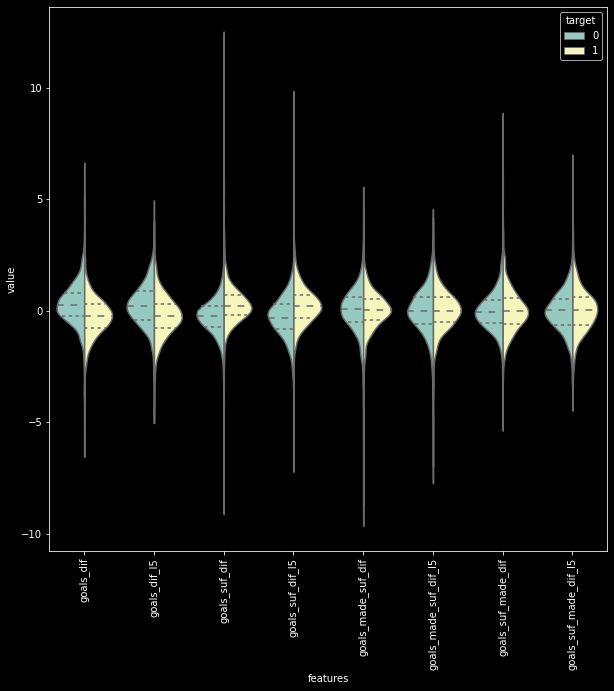

In [42]:
data_difs = dif.iloc[:, -8:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

goal difference is a good separator, but goals made difference and goals suffered difference aren't.

Now we can normalize the points earned based on the rank of teams faced.

In [43]:
dif.loc[:, "dif_points"] = dif["home_game_points_mean"] - dif["away_game_points_mean"]
dif.loc[:, "dif_points_l5"] = dif["home_game_points_mean_l5"] - dif["away_game_points_mean_l5"]
dif.loc[:, "dif_points_rank"] = dif["home_game_points_rank_mean"] - dif["away_game_points_rank_mean"]
dif.loc[:, "dif_points_rank_l5"] = dif["home_game_points_rank_mean_l5"] - dif["away_game_points_rank_mean_l5"]

In [44]:
dif.loc[:, "dif_rank_agst"] = dif["home_rank_mean"] - dif["away_rank_mean"]
dif.loc[:, "dif_rank_agst_l5"] = dif["home_rank_mean_l5"] - dif["away_rank_mean_l5"]

In [45]:
dif.loc[:, "goals_per_ranking_dif"] = (dif["home_goals_mean"] / dif["home_rank_mean"]) - (dif["away_goals_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif"] = (dif["home_goals_suf_mean"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_dif_l5"] = (dif["home_goals_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_mean_l5"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif_l5"] = (dif["home_goals_suf_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean_l5"] / dif["away_rank_mean"])

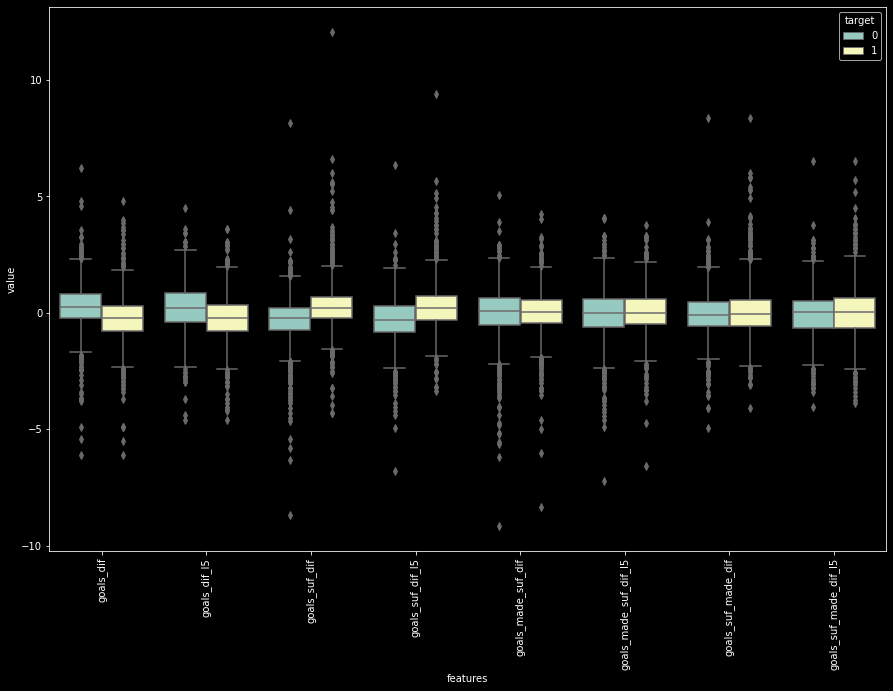

In [46]:
plt.figure(figsize=(15,10))
sns.boxplot(x="features", y="value", hue="target", data=violin)
plt.xticks(rotation=90)
plt.show()

Difference of points (full and last 5 games), difference of points by ranking faced (full and last 5 games) and difference of rank faced (full and last 5 games) are good features. Also, some of the generated features have very similar distributions which will be analyzed using scatterplots.

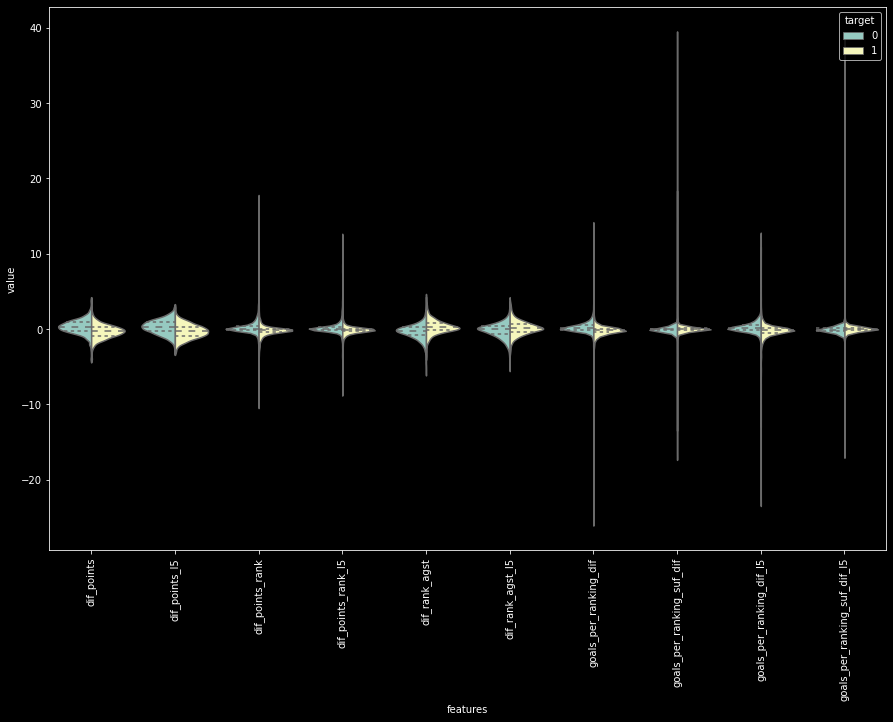

In [47]:
data_difs = dif.iloc[:, -10:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

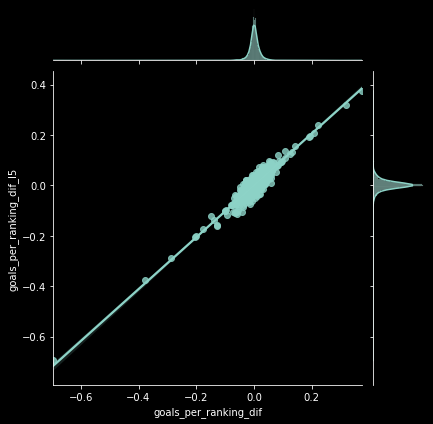

In [48]:
sns.jointplot(data = data_difs, x = 'goals_per_ranking_dif', y = 'goals_per_ranking_dif_l5', kind="reg")
plt.show()

Goals difference by ranking faced and its last 5 games version has very similar distributions. So, we will use only the full version (goals_per_ranking_dif).

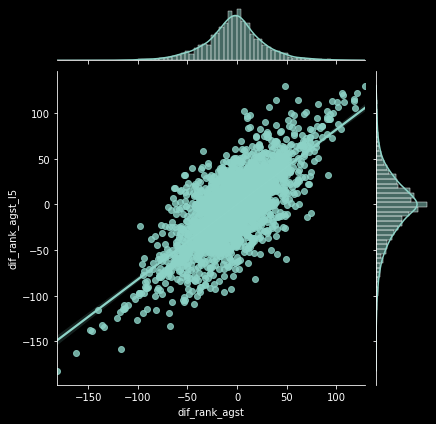

In [49]:
sns.jointplot(data = data_difs, x = 'dif_rank_agst', y = 'dif_rank_agst_l5', kind="reg")
plt.show()

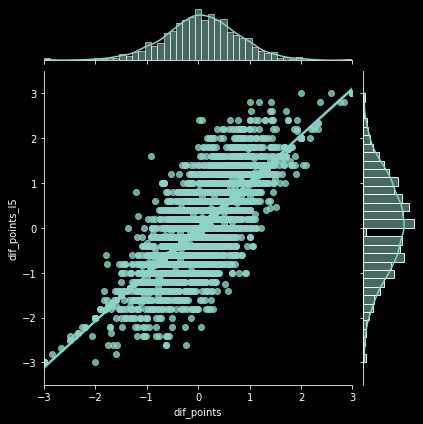

In [50]:
sns.jointplot(data = data_difs, x = 'dif_points', y = 'dif_points_l5', kind="reg")
plt.show()

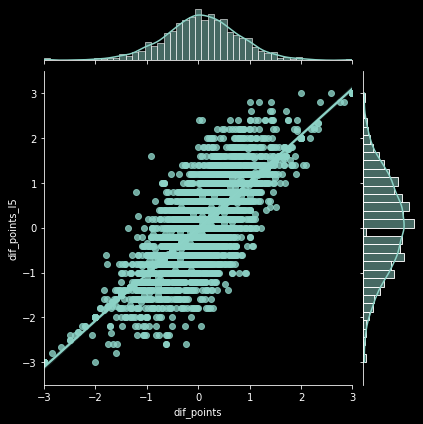

In [51]:
sns.jointplot(data = data_difs, x = 'dif_points', y = 'dif_points_l5', kind="reg")
plt.show()

For the differences of rank faced, game points by rank faced and mean game points by rank faced, the two versions (full and 5 games) are not so similar. So, we will use both.

In [52]:
def create_db(df):
    columns = ["home_team", "away_team", "target", "rank_diff", "home_goals_mean", "home_rank_mean", "away_goals_mean", "away_rank_mean", "home_rank_mean_l5", "away_rank_mean_l5", "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_l5", "away_goals_mean_l5", "home_goals_suf_mean_l5", "away_goals_suf_mean_l5", "home_game_points_rank_mean", "home_game_points_rank_mean_l5", "away_game_points_rank_mean", "away_game_points_rank_mean_l5","is_friendly_0", "is_friendly_1"]
    
    base = df.loc[:, columns]
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]
    
    model_df = base[["home_team", "away_team", "target", "rank_diff", "goals_dif", "goals_dif_l5", "goals_suf_dif", "goals_suf_dif_l5", "goals_per_ranking_dif", "dif_rank_agst", "dif_rank_agst_l5", "dif_points_rank", "dif_points_rank_l5", "is_friendly_0", "is_friendly_1"]]
    return model_df

In [53]:
model_db = create_db(df)

In [54]:
model_db

,home_team,away_team,target,rank_diff,goals_dif,goals_dif_l5,goals_suf_dif,goals_suf_dif_l5,goals_per_ranking_dif,dif_rank_agst,dif_rank_agst_l5,dif_points_rank,dif_points_rank_l5,is_friendly_0,is_friendly_1
4,Barbados,Cuba,1,-21.0,2.000000,2.0,1.000000,1.0,0.037037,-92.000000,-92.0,0.018519,0.018519,0,1
6,Barbados,Cuba,1,-21.0,1.000000,1.0,0.500000,0.5,0.008511,-35.500000,-35.5,0.008897,0.008897,0,1
31,Mongolia,Guam,1,-4.0,4.000000,4.0,-1.000000,-1.0,0.021622,0.000000,0.0,0.016216,0.016216,1,0
32,Nepal,Bhutan,0,-22.0,1.000000,1.0,0.000000,0.0,0.004975,7.000000,7.0,0.000000,0.000000,1,0
33,Bangladesh,Pakistan,0,-7.0,-1.000000,-1.0,-0.500000,-0.5,-0.007200,30.500000,30.5,-0.010437,-0.010437,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3331,Norway,Serbia,1,11.0,-0.038095,-0.8,-0.230159,0.0,-0.005282,9.014286,-3.4,-0.011343,0.016348,1,0
3332,Sweden,Slovenia,1,-45.0,0.030812,0.2,0.137255,0.2,0.009459,-25.102241,10.2,0.022485,-0.020314,1,0
3333,Kosovo,Cyprus,0,-2.0,0.667341,0.6,-0.463094,0.0,0.007625,7.037917,1.6,0.008791,-0.002827,1,0
3334,Greece,Northern Ireland,0,-9.0,0.067653,0.2,-0.369979,-1.2,-0.002915,16.024841,0.6,0.027775,0.018570,1,0


#### The Model

we'll be using random forest and gradent boosting

In [55]:
X = model_db.iloc[:, 3:]
y = model_db[["target"]]

In [56]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

In [58]:
import numpy as np

gb = GradientBoostingClassifier(random_state=5)

params = {"learning_rate": [0.01, 0.1, 0.5],
            "min_samples_split": [5, 10],
            "min_samples_leaf": [3, 5],
            "max_depth":[3,5,10],
            "max_features":["sqrt"],
            "n_estimators":[100, 200]
         } 

gb_cv = GridSearchCV(gb, params, cv = 3, n_jobs = -1, verbose = False)

gb_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             verbose=False)

In [59]:
gb = gb_cv.best_estimator_

In [60]:
params_rf = {"max_depth": [20],
                "min_samples_split": [10],
                "max_leaf_nodes": [175],
                "min_samples_leaf": [5],
                "n_estimators": [250],
                 "max_features": ["sqrt"],
                }

rf = RandomForestClassifier(random_state=1)

rf_cv = GridSearchCV(rf, params_rf, cv = 3, n_jobs = -1, verbose = False)

rf_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [20], 'max_features': ['sqrt'],
                         'max_leaf_nodes': [175], 'min_samples_leaf': [5],
                         'min_samples_split': [10], 'n_estimators': [250]},
             verbose=False)

In [61]:
rf = rf_cv.best_estimator_

In [62]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [63]:
def analyze(model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test.values)[:,1]) #test AUC
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train.values)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test.values)[:,1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train.values)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
    plt.show()
    
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y_test, model.predict(X_test.values))
    sns.heatmap(cm, annot=True, fmt="d")

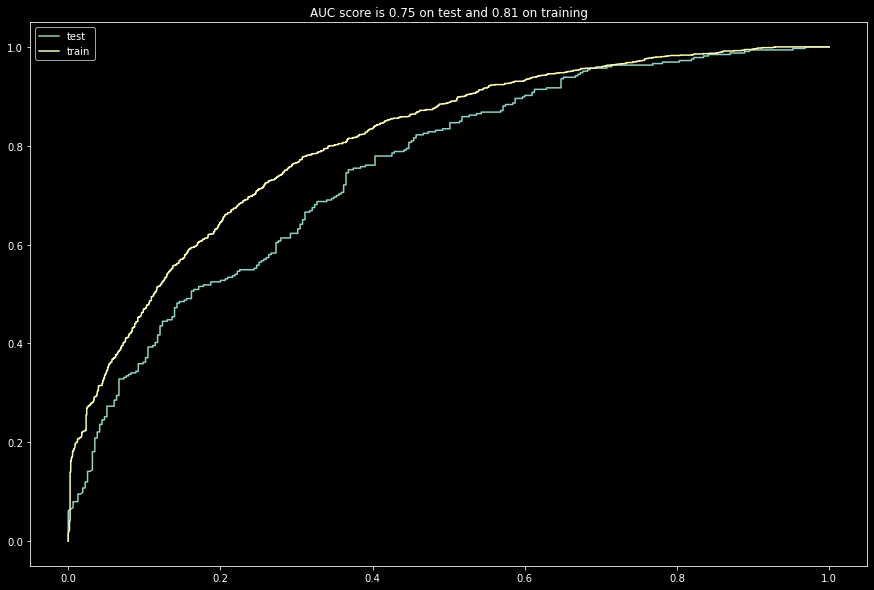

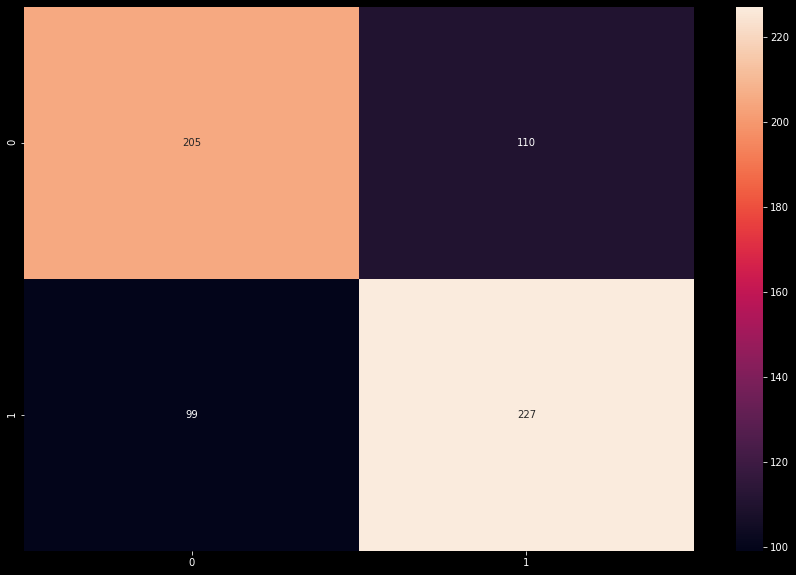

In [64]:
analyze(gb)

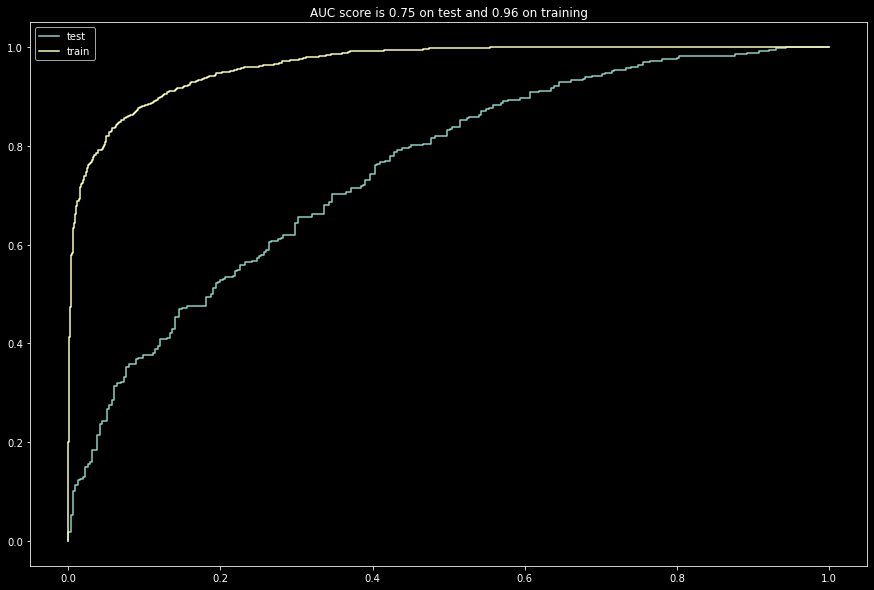

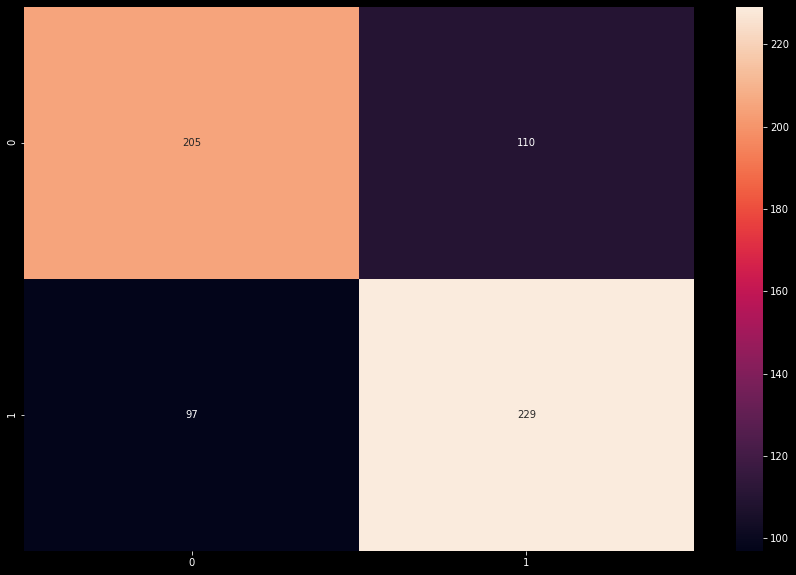

In [65]:
analyze(rf)

#### Simulation

In [66]:
from operator import itemgetter

In [67]:
dfs = pd.read_html(r"https://en.wikipedia.org/wiki/2022_FIFA_World_Cup#Teams")

In [68]:
from collections.abc import Iterable

for i in range(len(dfs)):
    df = dfs[i]
    cols = list(df.columns.values)
    
    if isinstance(cols[0], Iterable):
        if any("Tie-breaking criteria" in c for c in cols):
            start_pos = i+1

        if any("Match 46" in c for c in cols):
            end_pos = i+1

In [69]:
matches = []
groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
group_count = 0 

table = {}
#TABLE -> TEAM, POINTS, WIN PROBS (CRITERIO DE DESEMPATE)
table[groups[group_count]] = [[a.split(" ")[0], 0, []] for a in list(dfs[start_pos].iloc[:, 1].values)]

for i in range(start_pos+1, end_pos, 1):
    if len(dfs[i].columns) == 3:
        team_1 = dfs[i].columns.values[0]
        team_2 = dfs[i].columns.values[-1]
        
        matches.append((groups[group_count], team_1, team_2))
    else:
        group_count+=1
        table[groups[group_count]] = [[a, 0, []] for a in list(dfs[i].iloc[:, 1].values)]

In [70]:
table

{'A': [['Netherlands', 0, []],
  ['Ecuador', 0, []],
  ['Senegal', 0, []],
  ['Qatar', 0, []]],
 'B': [['England', 0, []],
  ['Wales', 0, []],
  ['United States', 0, []],
  ['Iran', 0, []]],
 'C': [['Saudi Arabia', 0, []],
  ['Poland', 0, []],
  ['Mexico', 0, []],
  ['Argentina', 0, []]],
 'D': [['France', 0, []],
  ['Tunisia', 0, []],
  ['Denmark', 0, []],
  ['Australia', 0, []]],
 'E': [['Spain', 0, []],
  ['Costa Rica', 0, []],
  ['Germany', 0, []],
  ['Japan', 0, []]],
 'F': [['Belgium', 0, []],
  ['Canada', 0, []],
  ['Morocco', 0, []],
  ['Croatia', 0, []]],
 'G': [['Brazil', 0, []],
  ['Serbia', 0, []],
  ['Switzerland', 0, []],
  ['Cameroon', 0, []]],
 'H': [['Portugal', 0, []],
  ['Ghana', 0, []],
  ['Uruguay', 0, []],
  ['South Korea', 0, []]]}

In [71]:
matches[:10]

[('A', 'Qatar', 'Ecuador'),
 ('A', 'Senegal', 'Netherlands'),
 ('A', 'Qatar', 'Senegal'),
 ('A', 'Netherlands', 'Ecuador'),
 ('A', 'Ecuador', 'Senegal'),
 ('A', 'Netherlands', 'Qatar'),
 ('B', 'England', 'Iran'),
 ('B', 'United States', 'Wales'),
 ('B', 'Wales', 'Iran'),
 ('B', 'England', 'United States')]

In [72]:
def find_stats(team_1):
#team_1 = "Qatar"
    past_games = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date")
    last5 = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date").tail(5)

    team_1_rank = past_games["rank"].values[-1]
    team_1_goals = past_games.score.mean()
    team_1_goals_l5 = last5.score.mean()
    team_1_goals_suf = past_games.suf_score.mean()
    team_1_goals_suf_l5 = last5.suf_score.mean()
    team_1_rank_suf = past_games.rank_suf.mean()
    team_1_rank_suf_l5 = last5.rank_suf.mean()
    team_1_gp_rank = past_games.points_by_rank.mean()
    team_1_gp_rank_l5 = last5.points_by_rank.mean()

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5]

In [73]:
def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0]

In [74]:
advanced_group = []
last_group = ""

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = gb.predict_proba([features_g1])
    probs_g2 = gb.predict_proba([features_g2])
    
    team_1_prob_g1 = probs_g1[0][0]
    team_1_prob_g2 = probs_g2[0][1]
    team_2_prob_g1 = probs_g1[0][1]
    team_2_prob_g2 = probs_g2[0][0]

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Group %s advanced: "%(last_group))
            
            for i in table[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Starting Analysis for Group %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Group %s - %s vs. %s: Winner %s with %.2f probability"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Group %s - %s vs. %s: Draw"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Winner Ecuador with 0.60 probability
Group A - Senegal vs. Netherlands: Winner Netherlands with 0.59 probability
Group A - Qatar vs. Senegal: Winner Senegal with 0.58 probability
Group A - Netherlands vs. Ecuador: Winner Netherlands with 0.66 probability
Group A - Ecuador vs. Senegal: Winner Ecuador with 0.53 probability
Group A - Netherlands vs. Qatar: Winner Netherlands with 0.69 probability


Group A advanced: 
Netherlands -------- 9
Ecuador -------- 6
Senegal -------- 3
Qatar -------- 0


---------- Starting Analysis for Group B ----------
Group B - England vs. Iran: Winner England with 0.60 probability
Group B - United States vs. Wales: Draw
Group B - Wales vs. Iran: Winner Wales with 0.54 probability
Group B - England vs. United States: Winner England with 0.58 probability
Group B - Wales vs. England: Winner England with 0.60 probability
Group B - Iran vs. United States: Winner United States with 0

In [75]:
advanced = advanced_group

In [76]:
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [77]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Round of 16":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
            

----------
Starting simulation of Round of 16
----------


Netherlands vs. United States: Netherlands advances with prob 0.55
Argentina vs. Denmark: Argentina advances with prob 0.59
Spain vs. Croatia: Spain advances with prob 0.57
Brazil vs. Uruguay: Brazil advances with prob 0.60
Ecuador vs. England: England advances with prob 0.65
Poland vs. France: France advances with prob 0.60
Germany vs. Belgium: Belgium advances with prob 0.50
Switzerland vs. Portugal: Portugal advances with prob 0.52
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Argentina: Netherlands advances with prob 0.52
Spain vs. Brazil: Brazil advances with prob 0.51
England vs. France: France advances with prob 0.51
Belgium vs. Portugal: Portugal advances with prob 0.52
----------
Starting simulation of Semi-Final
----------


Netherlands vs. Brazil: Brazil advances with prob 0.52
France vs. Portugal: Portugal advances with prob 0.52
----------
Starting simulation of Final
----------


Bra

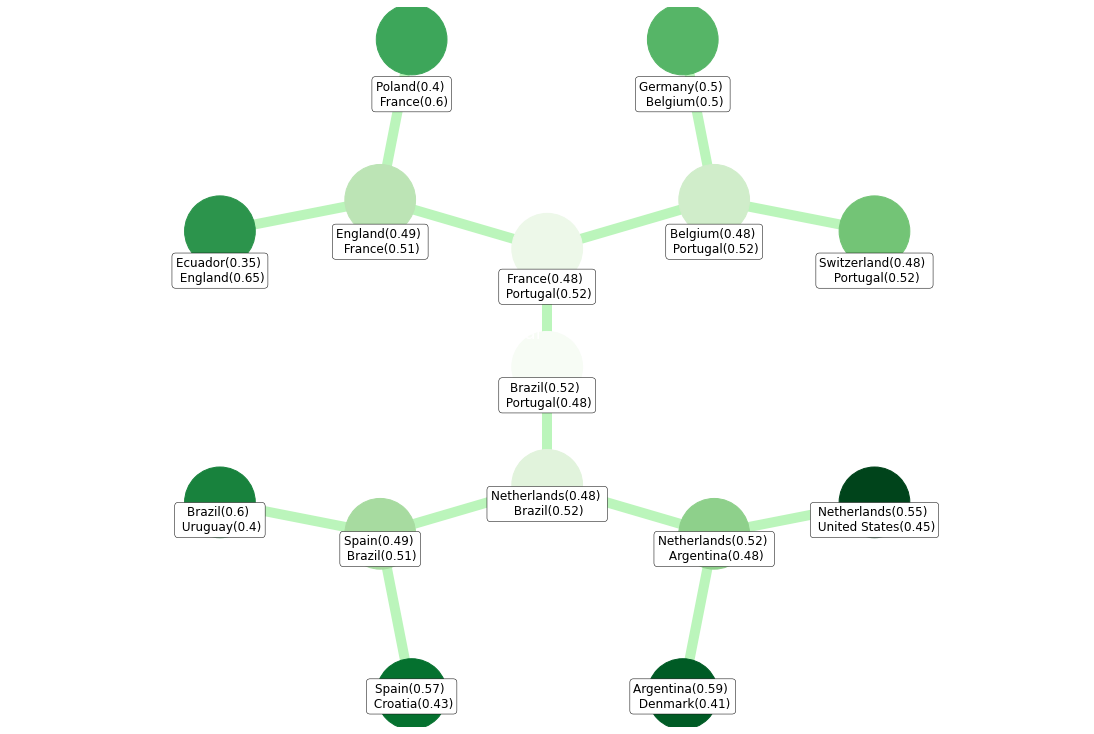

In [78]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

plt.figure(figsize=(15, 10))
G = nx.balanced_tree(2, 3)


labels = []


for p in playoffs.keys():
    for game in playoffs[p]:
        label = f"{game[0]}({round(game[2][0], 2)}) \n {game[1]}({round(game[2][1], 2)})"
        labels.append(label)
    
labels_dict = {}
labels_rev = list(reversed(labels))

for l in range(len(list(G.nodes))):
    labels_dict[l] = labels_rev[l]

pos = graphviz_layout(G, prog='twopi')
labels_pos = {n: (k[0], k[1]-0.08*k[1]) for n,k in pos.items()}
center  = pd.DataFrame(pos).mean(axis=1).mean()
    

nx.draw(G, pos = pos, with_labels=False, node_color=range(15), edge_color="#bbf5bb", width=10, font_weight='bold',cmap=plt.cm.Greens, node_size=5000)
nx.draw_networkx_labels(G, pos = labels_pos, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=labels_dict)
texts = ["Round \nof 16", "Quarter \n Final", "Semi \n Final", "Final\n"]
pos_y = pos[0][1] + 55
for text in reversed(texts):
    pos_x = center
    pos_y -= 75 
    plt.text(pos_y, pos_x, text, fontsize = 18)

plt.axis('equal')
plt.show()